# Projected gradient descent for simplex-constrained vector of Gamma variables

We are interested in minimizing a convex function $g: \mathbb{R}^D \rightarrow \mathbb{R}$ subject to the arguments belonging to simplex, $x\in\Delta_D$.

One approach to solving such a problem is via **projected gradient descent (projGD)**, which is the special case of **proximal gradient descent (PGD)**.
Proximal gradient descent can provide an efficient approach to solving non-differentiable convex functions, $f: \mathbb{R}^D \rightarrow \mathbb{R}$,
that can be decomposed into a smooth differentiable function, $g: \mathbb{R}^D \rightarrow \mathbb{R}$,
and a non-smooth function $h: \mathbb{R}^D \rightarrow \mathbb{R} \cup \{\infty\}$,
\begin{equation}
f(x) = g(x) + h(x).
\end{equation}
Projected gradient descent is the space case where $h$ is an indicator function onto a set; in our case, it is an indicator function for the $D$-dimensional simplex set.

Specifically, our problem can be stated as
\begin{align}
\textrm{minimize}\quad&g(x) \\
\textrm{subject to}\quad&x \in \Delta_D.
\end{align}

Let $\mathbb{I}$ be the indicator function that returns $1$ if the condition is met and $0$ otherwise.
Let $h(x) = -\log \mathbb{I}[x\in\Delta_D]$, which returns $0$ if the condition is met and $\infty$ otherwise.
This definition of $h$ is more consistent with the definitions of indicator functions typically discussed with respect to optimization algorithms.

The proximal gradient method is given as
\begin{align}
x^{(i+1)} \;\leftarrow\; \textbf{prox}_{h,\lambda^{(i)}}\left(x^{(i)}-\lambda^{(i)} \nabla g(x^{(i)})\right),
\end{align}
where $x^{(i)}$ denotes the $i$-th iteration of the argument, starting from some initial $x^{(0)}$, and $\lambda^{(i)}$ denotes the corresponding step size.
$\textbf{prox}_{h,\lambda}$ is the \textit{proximal operator} of function $h$ for step size $\lambda$ and is defined as
\begin{equation}
    \textbf{prox}_{h,\lambda}\left(x\right)
    = \underset{z}{\arg\min}\;
        \frac{1}{2\lambda} \Vert z - x \Vert^2_2
        + h(z).
\end{equation}
We note that, in general, the proximal operator itself involves solving a convex problem -- this explains the emphasis of PGD being efficient only for "simple" non-smooth functions $h$. As we will see shortly, the ease of evaluating $\textbf{prox}_{h,\lambda}$ becomes even more paramount when we introduce an inner loop for performing backtracking line search. In practice, PGD is used for a handful of functions for which the proximal operator can be evaluated quickly or for which an analytical solution exists; we refer readers to the Parikh and Boyd (2013) for a collection of such functions.

In the following sections, we develop the key ingredients for the proximal gradient method, consisting of efficient implementations of

1. The proximal operator for $h$, $\textbf{prox}_{h,\lambda}$, and
2. Adaptive approximation the step size, $\lambda^{(i)}$.


In [1]:
from functools import partial

from jax import jit, grad, lax, vmap
import jax.numpy as jnp
import jax.random as jr
import numpy as onp

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
AutoIntLocator = mpl.ticker.MaxNLocator(nbins='auto', steps=[1,2,5,10], integer=True)

# from typing import Callable, Optional, Sequence
# from jax.typing import ArrayLike
# from jax import Array
# KeyArray = Array


# from tqdm.auto import tqdm

# import jax
# import jax.scipy as jsp

# import tensorflow_probability.substrates.jax as tfp
# tfd = tfp.distributions

### Simple example: Six-hump camel fuunction

First, let's define an "easy" objective function with which to perform preliminary evaluations.
The six-hump camel function is a completely smooth function.
So, the composite objective is exactly $f(x) = g(x)$, i.e. i.e. $h(x) = 0$ for all $x$.
The corresponding proximal operator of $h$ is the identity function, 
$$\textbf{prox}_{h,\lambda}(x) = x.$$

As we have discussed, proximal gradient descent is exactly gradient descent, and the generalized gradient is exactly the gradient of $g$,
$$
G_{f,\lambda} = \nabla g.
$$

This function has 6 local minima, two of which are global minima.
The global minimum is $f(x^\star) = -1.0316$ at, with minima at
$x^\star = \{(0.0898, -0.7126), (-0.0898, 0.7126)\}$.

In [ ]:
def sixhump2d(x):
    """Six-hump camel function for 2D inputs.

    This function has 6 local minima, two of which are global.
    
    The global minimum is f(x*) = -1.0316 at
        x* = (0.0898, -0.7126) and (-0.0898, 0.7126)
    
    Parameters
        x: Array, shape [...,2].

    returns
        Array, shape [...,]

    Sources:
        Molga, M., & Smutnicki, C. Test functions for optimization needs (2005).
        http://www.zsd.ict.pwr.wroc.pl/files/docs/functions.pdf

        Scientific Python Lectures, Optimization of a two-parameter function.
        http://scipy-lectures.org/intro/scipy/auto_examples/plot_2d_minimization.html

    """

    return (
        (4 - 2.1*x[...,0]**2 + x[...,0]**4 / 3.) * x[...,0]**2
        + x[...,0] * x[...,1]
        + (-4 + 4*x[...,1]**2) * x[...,1] **2
    )

Text(0.5, 0.98, 'Six-hump camel function')

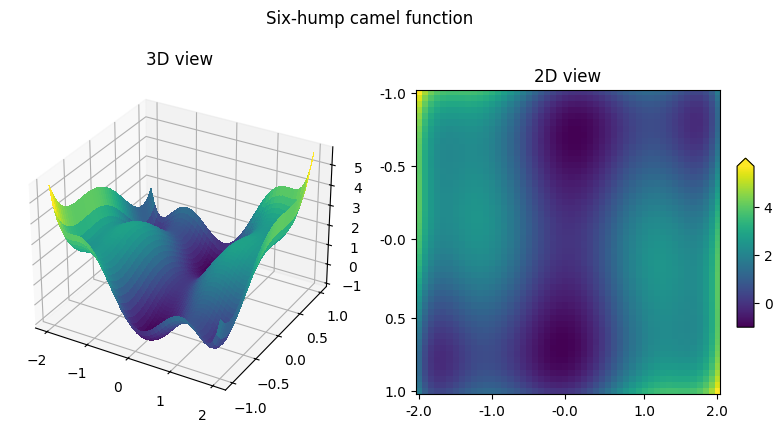

In [ ]:
# Visualize the objective function

# Make mesh grid
i = onp.linspace(-2, 2)
j = onp.linspace(-1, 1)
ii, jj = onp.meshgrid(i, j)

# Evaluate function
kk = sixhump2d(onp.stack([ii,jj], axis=-1))

# ---------------------------------------------------------

# Set up a figure that is half as tall as it is wide
fig = plt.figure(figsize=plt.figaspect(0.5))

# Show 3D surface
ax = fig.add_subplot(1,2,1,projection='3d')
surf = ax.plot_surface(ii, jj, kk, cmap=mpl.cm.viridis,
                       linewidth=0, antialiased=False)

ax.set_title('3D view')

# Show 2D surface
ax = fig.add_subplot(1,2,2)
im = ax.imshow(kk, cmap=mpl.cm.viridis)

# Set x-axis ticks
idxs = onp.round(onp.linspace(0, len(i) - 1, 5)).astype(int)
ax.xaxis.set_major_formatter('{x:.1f}')
ax.set_xticks(idxs)
ax.set_xticklabels([f'{i[idx]:.1f}' for idx in idxs])

# Set y-axis ticks
idxs = onp.round(onp.linspace(0, len(j) - 1, 5)).astype(int)
ax.set_yticks(idxs)
ax.set_yticklabels([f'{j[idx]:.1f}' for idx in idxs])

ax.set_title('2D view')

# # Add a color bar which maps values to colors.
plt.colorbar(im, shrink=0.5, fraction=0.05, aspect=10, extend='max')

fig.suptitle('Six-hump camel function')

In [ ]:
# # Let's consider a synthetic linear regression with lasso regularization

# n = 100  # number of examples
# d = 10   # dimensionaltiy
# key = jr.key(3240)
# key_1, key_2, key_3 = jr.split(key, 3)

# W = jr.normal(key_1, (100,10)) * 3
# true_x = jr.normal(key_2, (10,))*5 + 5
# y = W @ true_x

### Backtracking line search
The proximal gradient method can be re-written as
\begin{equation}
x^{(i+1)} \;\leftarrow\; x^{(i)} - \lambda^{(i)}G_{f,\lambda^{(i)}}\left(x\right),
\end{equation}
where $G_{f,\lambda}$ is the _generalized gradient_ of $g$ with step size $\lambda$,
\begin{equation}
    G_{f,\lambda}(x) = \frac{x - \textbf{prox}_{h,\lambda}\left(x-\lambda \nabla g(x)\right)}{\lambda}.
\end{equation}
Indeed, when $f$ is smooth and differentiable, that is, $h(x)=0$, the corresponding proximal operator is the identity mapping, $\textbf{prox}_{h,\lambda}\left(x\right) = x$, and the generalized gradient of $f$ is exactly the gradient of $g$,
\begin{equation*}
    G_{f,\lambda}(x)
    = \frac{x - \left(x - \lambda \nabla g(x)\right)}{\lambda}
    = \nabla g(x).
\end{equation*}
Moreover, the generalized gradient inherits many of the properties of a regular gradient. This facilitates porting over many of the algorithms originally developed for gradient descent, such as approximating the step size via backtracking line search.

Beck and Teboulle (2008) proposed a backtracking line search algorithm that...

We will use this function to perform some initial evaluations of the our implementations.

**While-loop formulation**

In [ ]:
def backtrack_while_loop(x,
                         objective,
                         prox,
                         init_stepsize: float=1.,
                         alpha: float=0.3,
                         beta: float=0.6,
                         max_steps: int=100):
    """Perform backtracking line search with while-loop formulation.

    For parameter descriptions, please see ``backtrack_vec`` implemented in the next cell.

    """

    g = objective
    dg = grad(g)

    # Check if sufficient decrease achieved, or max number of steps exceeded
    def cond(carry):
        stepsize, counter = carry

        # Compute the generalized gradient at x given step size t
        Gxt = (x - prox(x - stepsize * dg(x), stepsize)) / stepsize

        # Evaluate objective at proposed updated value
        new_obj = g(x - stepsize * Gxt)

        # Compute upper bound on objective via quadratic Taylor approx
        upper_bound = g(x) \
            - stepsize * jnp.sum(dg(x) * Gxt) \
            + alpha * stepsize * jnp.sum(Gxt**2)

        # Equivalent formulation (used in backtrack_vec) that eliminates
        # the extra division and multiplication by stepsize
        # # Evaluate objective at proposed updated value
        # new_x = prox(x - stepsize * dg(x), stepsize)
        # new_obj = g(new_x)

        # # Compute upper bound on objective via quadratic Taylor approx
        # upper_bound = g(x) \
        #     - jnp.sum(dg(x) * (x - new_x)) \
        #     + alpha / stepsize * jnp.sum((x - new_x)**2)

        # # If objective exceeds upper bound, continue to decrease stepsize
        return (new_obj > upper_bound) & (counter < max_steps)

    # Decrease step size by factor beta; increase step counter
    def body(carry):
        stepsize, counter = carry
        return beta * stepsize, counter + 1

    # Run backtracking line search to find the stepsize that decreases the objective
    # below the upper bound
    stepsize, n_steps = lax.while_loop(cond, body, (init_stepsize, 0))

    return stepsize, n_steps

**Vectorized formulation**

In this vectorized formulation, we precompute all of the stepsizes (up to the specified maximum number of steps), then compute the objective values and upper bound at the corresponding new parameter values. We then simply return the stepsize at which the sufficient descent criterion is first achieved.

In [ ]:
def backtrack_vec(x,
                  objective,
                  prox,
                  init_stepsize: float=1.,
                  alpha: float=0.3,
                  beta: float=0.6,
                  max_steps: int=100):
    """Perform backtracking line search via vectorization
    
    Let t denote the current step size. The stopping criterion is met when
    a step size is chosen so as to achieve sufficient decrease in the objective,
        g(x - t*dg(x)) < g(x) - t <dg(x), G(x,t)> + alpha * t ||G(x,t)||^2
    where dg is the gradient of the objective and G is the generalized gradient of
    the objective function and the proximal function.
    with a slope shrinkage factor controlled by parameter alpha.
    When alpha=0.5, the right-hand side is exactly the quadratic Taylor exapansion
    If the criterion is not achieved, shrink t by a factor of beta.

    Recommened parameter values or ranges are given in Boyd and Vandenberghe, 2004 (p.466).

    Parameters:
        x: Array. Current parameter value.
        objective: Callable[[Array], float]. Smooth convex objective function.
        prox: Callable[[Array, float], Array]. Proximal operator of non-smooth function.
        init_stepsize: float, default=1.0
            Initial stepsize multiplier for the gradient
        alpha: float, between 0 and 0.5. default = 0.3
            Factor of decrease in linear extrapolation of the objective g that we want
            to achieve by taking a step. Values closer to 0.5 indicate smaller decreases
            while values closer to 0 indicate greater decrease criterion.
            This parameter is typically chosen to be in the range [0.01, 0.3].
        beta: float, between 0 and 1. default = 0.6.
            Factor by which to reduce stepsize at each iteration. Values closer to 1
            correspond to finer step size searches; values closer to 0 lead to very
            crude searches. This parameter is typically chosen to be between [0.1, 0.8].
        max_steps: int. default = 100. 
            Max number of backtracking line steps to take. Theoretically, backtracking
            line search will always terminate; this sets an upper bound on the maximum
            number of steps that we will consider.
        
    Returns:
        stepsize: float.
        n_steps: int. Number of backtracking steps taken.
    """

    g = objective
    dg = grad(g)

    # Precompute all possible stepsizes that we would've considered
    pows = jnp.arange(max_steps)
    stepsizes = (beta ** pows) * init_stepsize

    # Compute the parameter updates and the objective values corresponding
    # to each step size
    new_xs = vmap(lambda t: prox(x - t*dg(x), t))(stepsizes)
    new_objs = g(new_xs)

    # Compute the upper bounds
    ubs = vmap(lambda new_x, stepsize: 
        g(x) - jnp.sum(dg(x) * (x-new_x)) + alpha / stepsize * jnp.sum((x-new_x)**2)
    )(new_xs, stepsizes)

    # Take the first index for (new_obj > ub) is False, i.e. (new_obj <= ub)
    # It is possible for the criteria to be not fulfilled with some smaller step sizes
    # so using `sum(new_objs > ubs)` may over-estimate the number of steps needed.
    n_steps = jnp.argmin(new_objs > ubs)

    return stepsizes[n_steps], n_steps

First, we evaluate whether the two implementations give us the same results.

In [ ]:
n_samples = 10
xs = jr.normal(key, (n_samples, 2)) * jnp.array([2,1])

g = sixhump2d
prox = lambda x, _: x  # proximal operator of h(x) = 0 is identity

stepsizes_vec, n_steps_vec = vmap(partial(backtrack_vec, objective=sixhump2d, prox=prox))(xs)
stepsizes_while, n_steps_while = vmap(partial(backtrack_while_loop, objective=sixhump2d, prox=prox))(xs)

assert jnp.allclose(stepsizes_vec, stepsizes_while, atol=1e-3)

Now, let's time the implementations over the different examples.
This gives a better sense of how each algorithm performs on average,
when given points from different parts of the loss landscape.

In [ ]:
%timeit vmap(partial(backtrack_vec, objective=sixhump2d, prox=prox))(xs)

82.9 ms ± 4.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit vmap(partial(backtrack_while_loop, objective=sixhump2d, prox=prox))(xs)

308 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We observe that the vectorized backtracking is about 3 times faster,
_even though_ it computes all 100 possible stepsizes and the while loop only iterates through 10% of those stepsizes.

In [ ]:
print("number of backtracking steps for each point: ", n_steps_vec)

number of backtracking steps for each point:  [ 5  5 11 10  0 12  4  8 16  5]


We expecrt the vectorized implementation to perform better in worst case situations when the maximum alloted number of stepsizes needs to be used.

### Proximal gradient descent

In [ ]:
def prox_grad_descent_while_loop(x0,
                                 objective,
                                 prox,
                                 linesearch,
                                 max_steps=100,
                                 tol=1e-6,
                                 verbosity=0):
    """Proximal gradient descent with backtracking line search with while-loop formulation.
    
    For parameter descriptions, please see ``backtrack_vec`` implemented in the next cell.

    """

    g = objective
    dg = grad(objective)

    # Check if convergence tolerance achieved, or max number of steps exceeded
    def cond(carry):
        _,  old_obj, curr_obj, counter = carry
        return (abs(curr_obj - old_obj) > tol) & (counter <= max_num_steps)

    def body(carry):
        x, _, curr_obj, counter = carry

        # Find the best stepsize at given location
        stepsize, _ = linesearch(x, objective)

        # Perform parameter update
        G = (x - prox(x - stepsize * dg(x), stepsize)) / stepsize
        new_x = x - stepsize * G
        new_obj = g(new_x)
        
        return new_x, curr_obj, new_obj, counter + 1

    x_opt, _, _, n_steps = lax.while_loop(cond, body, (x0, jnp.inf, 0.0, 0))

    return x_opt, n_steps

In [ ]:
def prox_grad_descent_scan(x0,
                           objective,
                           prox,
                           linesearch,
                           max_steps=100,
                           tol=1e-6,
                           verbosity=0):
    """Proximal gradient descent with backtracking line search.

    Implemented using a lax.scan function instead of lax.while_loop
    
    Parameters:
        x0: Initial parameter values.
        objective: Callable[[Array], float]. Smooth convex objective function, g.
        prox: Callable[[Array, float], Array]. Proximal operator on non-smooth function, h.
        linesearch: Callable[[], float]. Line search function.
        max_steps: int. default = 100.
            Maximum number of steps to run.
        tol: float. default=1e-6.
            Convergence condition.
    
    Return:
        x_opt: Optimized parameter values
        n_steps: int. Number of gradient descent steps.
    """

    g = objective
    dg = grad(objective)

    def step(carry, _):
        x = carry

        # Find the best stepsize at given location
        stepsize, n_inner_steps = linesearch(x, g)

        # Perform parameter update
        G = (x - prox(x - stepsize * dg(x), stepsize)) / stepsize
        new_x = x - stepsize * G
        new_obj = g(new_x)
        
        return new_x, (new_x, new_obj, stepsize, n_inner_steps)

    _, (xs, objs, stepsizes, n_inner_steps) = lax.scan(step, x0, length=max_steps)

    # Post hoc evaluate number of steps needed to reach convergence
    n_steps = jnp.argmin(abs(objs[1:] - objs[:-1]) > tol)

    return x_opt, n_steps

In [219]:
# Evaluation, to do

## Projection onto the simplex
Let $\mathbb{I}_\mathcal{C}: \mathbb{R}^D \rightarrow \{0,1\}$ be the indicator function that returns $1$ if the constraint(s) $\mathcal{C}$ is met and $0$ otherwise.
Let $h(x) = -\log \mathbb{I}_\mathcal{C}(x)$, which returns $0$ if the condition is met and $\infty$ otherwise.
This definition of $h$ is consistent with the more typical definitions of indicator functions typically discussed with respect to optimization algorithms.
The proximal operator of indicator functions onto a set is simply the projection mapping onto said set.

For the indicator function onto the simplex set,
\begin{equation}
h(x) = -\log \mathbb{I}_{\Delta}(x),
\end{equation}
the proximal operator is then
\begin{equation}
\textbf{prox}_{h,\lambda}\left(x\right) = \ldots
\end{equation}
We have omitted the subscript indicating the dimensionality of the simplex set for clarity.

The resulting proximal operator of $g$ is simply the projection onto the simplex (see e.g. derivation by [Ang (2023)](https://angms.science/doc/CVX/Proj_simplex.pdf)).
This projection step can be solved with a bisection algorithm (see Section 6.2.25 of Parikh and Boyd (2013)), or more efficiently by sorting (see [Duchi et al. (2008)](https://stanford.edu/~jduchi/projects/DuchiShSiCh08.pdf)),


In [2]:
def project_simplex(x, stepsize=None):
    """Project a D-dimensional vector onto the simplex.
    
    Duchi et al. (2008), https://stanford.edu/~jduchi/projects/DuchiShSiCh08.pdf,
    and following the implementation provided in Wang and Carreira-Perpinan (2013),
    https://home.ttic.edu/~wwang5/papers/SimplexProj.pdf

    Params:
        x: shape (D,)
        stepsize: float. Not used

    Return:
        proj_x: shape (D,). Point on the simplex.
    """

    # sort input vector from highest to lowest elements
    x_sorted = jnp.sort(x, descending=True)

    # enumerate all possible breakpoints
    mus = jnp.cumsum(x_sorted) - 1  # sum x_i from i = 1,...,j
    mus /= jnp.arange(len(x), dtype=float) + 1  # divide by j

    # find index of last breakpoint for which x_sorted - mu > 0
    j_opt = sum(x_sorted > mus) - 1

    return jnp.maximum(0, x-mus[j_opt])

Let's check that this function does what we expect! The projected vectors should all be positive elements and sum to 1.

2024-11-13 18:43:18.693242: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


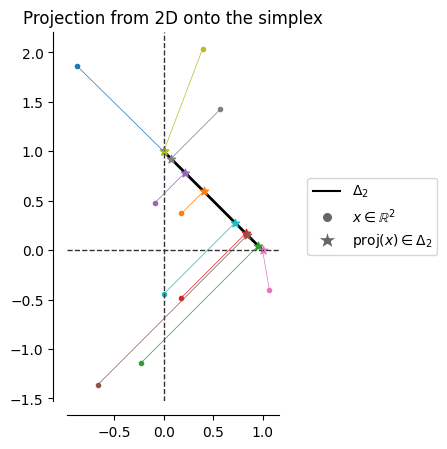

In [3]:
# 2d case -- easy to visualize it!
key = jr.key(4312)
n_examples = 10
xs = jr.normal(key, shape=(n_examples, 2))

proj_xs = vmap(project_simplex)(xs)

ax = plt.gca()

# Draw simplex
ax.plot([0,1], [1,0], lw=2, color='k', zorder=1)
ax.axvline(0, lw=1, color='0.2', ls='--')
ax.axhline(0, lw=1, color='0.2', ls='--')

# Draw points and their projections
for x, proj_x in zip(xs, proj_xs):
    sc = ax.scatter(x[0], x[1], marker='.')
    c = sc.get_facecolors()

    ax.scatter(proj_x[0], proj_x[1], marker='*', c=c)
    ax.plot([x[0], proj_x[0]], [x[1], proj_x[1]], lw=0.5, c=c)

# Show legend
legend_elements = [
    mpl.lines.Line2D([0], [0], color='k', label=r'$\Delta_2$', ),
    mpl.lines.Line2D([0], [0], marker='.', color='w', mfc='0.4', markersize=15, label=r'$x \in \mathbb{R}^2$', ),
    mpl.lines.Line2D([0], [0], marker='*', color='w', mfc='0.4', markersize=15, label=r'proj$(x) \in \Delta_2$'),
]
plt.legend(handles=legend_elements, bbox_to_anchor=[1.1,0.5], loc='center left')

# Show title
plt.title(r'Projection from 2D onto the simplex')

# make pretty
ax.set_aspect('equal')
sns.despine(offset=10)

In [4]:
# 3d case
with jnp.printoptions(precision=2):
    for name, w in [
        ("Noneg vec", jnp.array([0.2, 0.9, 1.4])),
        ("Real vec", jnp.array([-0.4, 0.9, 0.2])),
        ("Simplex vec", jnp.array([0.33, 0.33, 0.33])),
        ("a-simplex vec", jnp.array([3.3, 3.3, 3.3])),
    ]:
        v = project_simplex(w)
        print(f"{name}:\t proj({w})\t-> {v}")
        assert jnp.all(v >= 0) & jnp.isclose(v.sum(), 1.0)

Noneg vec:	 proj([0.2 0.9 1.4])	-> [0.   0.25 0.75]
Real vec:	 proj([-0.4  0.9  0.2])	-> [0.   0.85 0.15]
Simplex vec:	 proj([0.33 0.33 0.33])	-> [0.33 0.33 0.33]
a-simplex vec:	 proj([3.3 3.3 3.3])	-> [0.33 0.33 0.33]


### Proximal operator to project onto the simplex

Here, we implement the simplex projection function via sorting (Duchi et al. (2008)).

An implementation of the bisection algorithm may be found in earlier notebooks
or in the original ["Convex optimization on simplex by proximal gradient descent (colab)"](https://colab.research.google.com/drive/1SI2MRM_zHfHHwQDbjQORtssg1ixu7v7x?authuser=2#scrollTo=Pa4fo_PWeZnb) notebook.

Our parameter updates for the topics, $\mathbf{\theta}_k \in \Delta_V$ for $k=1,\ldots,K$, involve minimizing the negative log likelihood of a $V$ independent Gamma variables, $f(x)$, subject to $x \in \Delta_V$. The same type of updates are also needed for the weights, $\mathbf{w}_m \in \Delta_K$, and scale, $\sigma\in\Delta_V$ parameters.

Since $f(x)$ is a convex function, one way we can solve this method is through **proximal gradient descent** (see Section 4.2 of Parikh and Boyd (2013)).

The key ingredient is the proximal operator, $\textrm{prox}_{\lambda g}$, for step size $\lambda$ and function $g$. In our case, $g$ is the simplex indicator function,
$$
g(x) = \begin{cases}0 &\textrm{if } x \in \Delta_V \\ +\infty &\textrm{otherwise}\end{cases}.
$$


### Simplex-constrained independent Gamma optimziation

Now, we combine the PGD algorithm and the simplex projection operator with our objective,

$$
\underset{{\mathbf{x} \in \Delta_d}}{\textrm{maximize}}\;
f(\mathbf{x}; \mathbf{\alpha}, \mathbf{\beta}) = \sum_{i=1}^d \ln \textrm{Gamma}(x_i \mid \alpha_i, \beta_i)
$$
whre $\mathbf{\alpha}=(\alpha_1,\ldots, \alpha_d), \mathbf{\beta}=(\beta_1,\ldots,\beta_d)$ are the posterior sufficient statistics.

In [15]:
def gamma_dirichlet_pgd(x0, alpha, beta, amin=1e-4, max_stepsize=1e0, max_num_steps=100):
    
    # Standardize params to be order 1
    c = jnp.maximum(alpha.max(), beta.max())
    alpha = 1. + (alpha-1) / c
    beta = beta / c

    gamma_objective = lambda x: \
        -1.0 * tfd.Gamma(alpha, rate=beta).log_prob(jnp.clip(x, min=amin)).mean()

    return prox_grad_descent(
        gamma_objective, project_simplex, x0,
        max_stepsize=max_stepsize, max_num_steps=max_num_steps
    )

# vmap over initial params, alpha, and beta
v_gamma_dirichlet_pgd = vmap(gamma_dirichlet_pgd, in_axes=(0,0,0,None,None))